In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

To test GNNs, we generate synthetic graph datasets where 2 classes differ by some controlled measures, like degree, centrality, etc.

## Constructing a list of undirected graphs with low/high degree

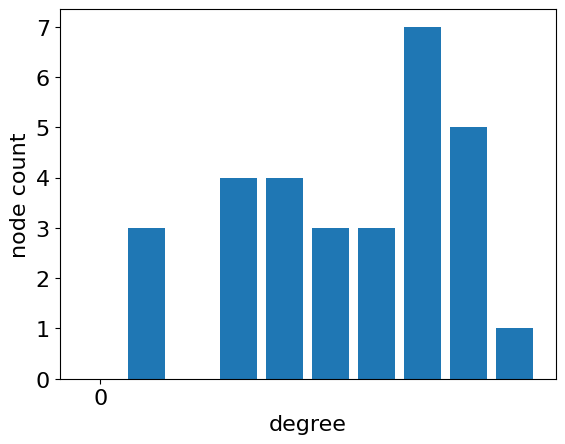

mean degree: 9.95
density: 0.18620689655172415


In [20]:
# number of nodes
n = 30
# probability of cnnection
p = 0.2

G = nx.fast_gnp_random_graph(n, p, directed=False)

hist_deg = nx.degree_histogram(G)

plt.figure()
plt.bar(range(len(hist_deg)), hist_deg)
plt.xticks(range(0,len(hist_deg),10))
plt.xlabel('degree')
plt.ylabel('node count')
plt.show()

print('mean degree:', np.mean(nx.degree(G)))
print('density:', nx.density(G))

In [46]:
# number of graph samples
n_sample = 100

# list of graphs and labels
list_G = []
labels = []

for i in range(n_sample):
    # adjust parameters depending on class
    if i<n_sample/2:
        l = 0
        p = 0.2
    else:
        l = 1
        p = 0.3
    list_G.append(nx.fast_gnp_random_graph(n, p, directed=False))
    labels.append(l)
    
labels = np.array(labels)    

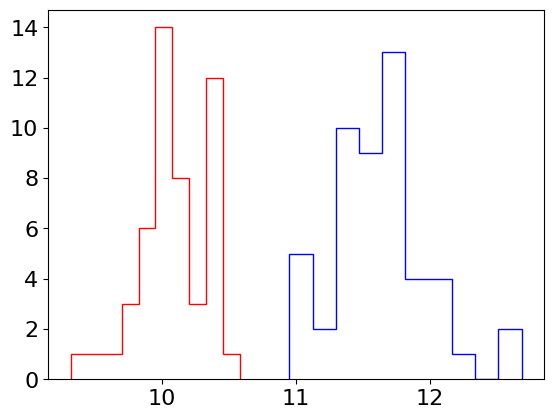

In [47]:
mean_deg = []

for G in list_G:
    mean_deg.append(np.mean(nx.degree(G)))

mean_deg = np.array(mean_deg)
    
plt.figure()
plt.hist(mean_deg[labels==0], histtype='step', color='red')
plt.hist(mean_deg[labels==1], histtype='step', color='blue')
plt.show()

## Constructing a list of undirected graphs with community (but similar degree and eigenvector centrality)

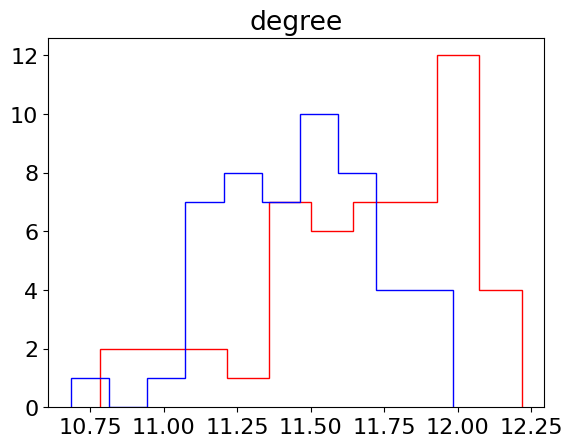

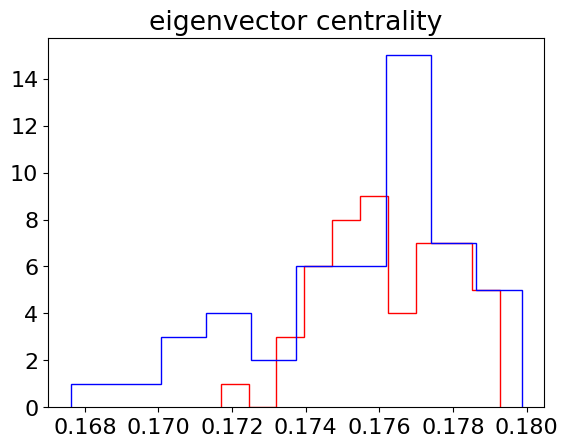

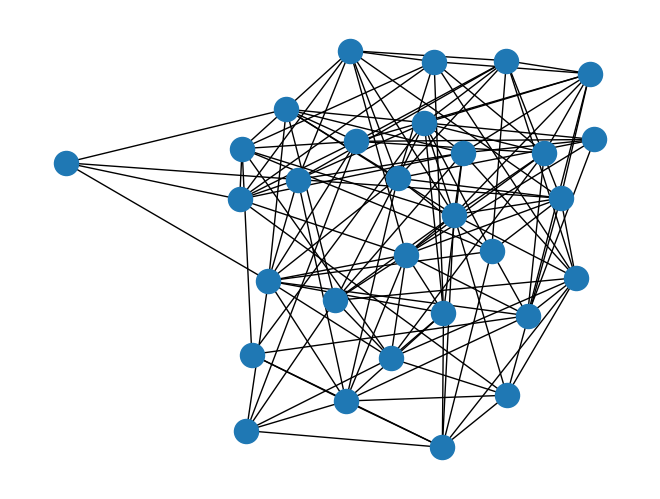

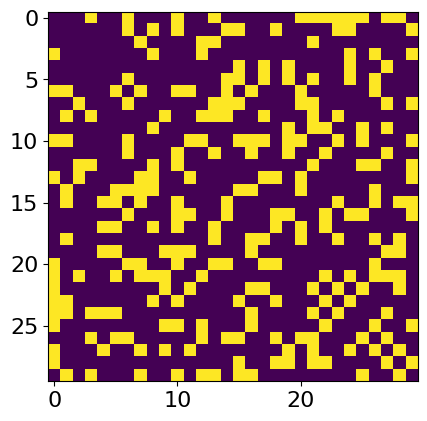

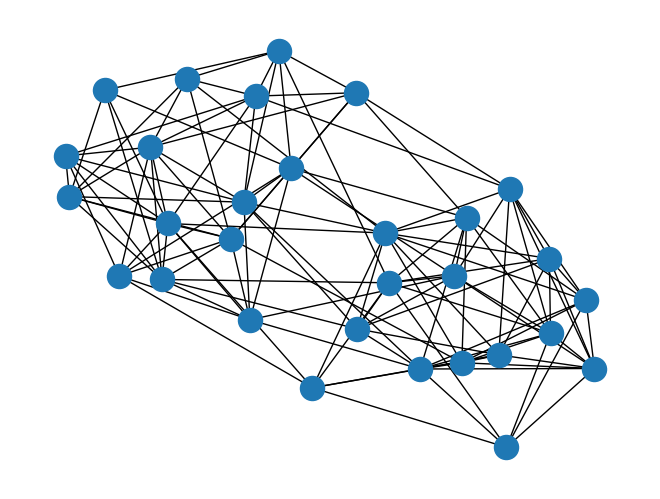

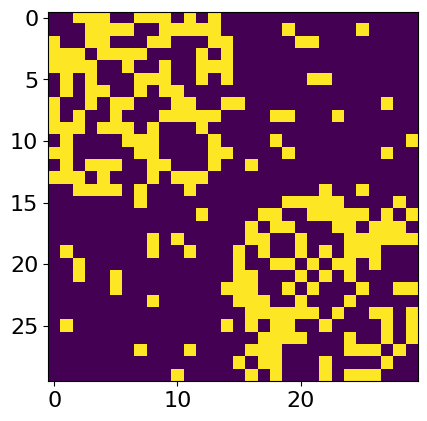

In [71]:
# number of graph samples
n_sample = 100

# list of graphs and labels
list_G = []
labels = []
mean_deg = []
mean_ec = []

for i in range(n_sample):
    if i<n_sample/2:
        l = 0
        p = 0.0
    else:
        l = 1
        p = 0.2
    sizes = [int(n/2), int(n/2)]
    G = nx.random_partition_graph(sizes, p_in=0.3+p, p_out=0.3-p)
    
    list_G.append(G) # connected to 4 neighbors before rewiring
    labels.append(l)
    
    # check eignevctor centrality
    mean_deg.append(np.mean(nx.degree(G)))
    mean_ec.append(np.mean(list(nx.eigenvector_centrality(G, max_iter=500).values())))
    
labels = np.array(labels)
mean_deg = np.array(mean_deg)
mean_ec = np.array(mean_ec)

plt.figure()
plt.title('degree')
plt.hist(mean_deg[labels==0], histtype='step', color='red')
plt.hist(mean_deg[labels==1], histtype='step', color='blue')
plt.show()

plt.figure()
plt.title('eigenvector centrality')
plt.hist(mean_ec[labels==0], histtype='step', color='red')
plt.hist(mean_ec[labels==1], histtype='step', color='blue')
plt.show()

plt.figure()
plt.imshow(nx.linalg.adjacency_matrix(list_G[0]).todense())

plt.figure()
plt.imshow(nx.linalg.adjacency_matrix(list_G[-1]).todense())